#Task1: Generating tf records

In [ ]:
import os
import tensorflow as tf
from tqdm import tqdm
import xml.etree.ElementTree as ET
from PIL import Image
import numpy as np

In [ ]:
# Function to read XML annotation file
def read_xml_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Extract image information
    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)
    format = filename.split('.')[-1]

    # Extract object information
    xmin, ymin, xmax, ymax = [], [], [], []
    class_text, label, difficult, truncated, view = [], [], [], [], []
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin.append(float(bbox.find('xmin').text) / width)
        ymin.append(float(bbox.find('ymin').text) / height)
        xmax.append(float(bbox.find('xmax').text) / width)
        ymax.append(float(bbox.find('ymax').text) / height)
        class_text.append(obj.find('name').text)
        # Append the correct label based on the class name
        label.append(class_mapping[obj.find('name').text])
        difficult.append(int(obj.find('difficult').text))
        truncated.append(int(obj.find('truncated').text))

    return {
        'filename': filename,
        'width': width,
        'height': height,
        'format': format,
        'xmin': xmin,
        'xmax': xmax,
        'ymin': ymin,
        'ymax': ymax,
        'class_text': class_text,
        'label': label,
        'difficult': difficult,
        'truncated': truncated,
    }

# Function to load image data
def load_image(image_path):
    with Image.open(image_path) as img:
        img = img.convert('RGB')
        img = np.array(img)
        encoded_img = tf.io.encode_jpeg(img)
    return encoded_img

# Function to create TFRecord example from sample
def create_tf_example(sample, image_folder):
    image_path = os.path.join(image_folder, sample['class'], sample['filename'])
    encoded_image = load_image(image_path)

    feature = {
        "image/width": tf.train.Feature(int64_list=tf.train.Int64List(value=[sample['width']])),
        "image/height": tf.train.Feature(int64_list=tf.train.Int64List(value=[sample['height']])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[sample['filename'].encode('utf-8')])),
        'image/encodedrawdata': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_image.numpy()])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=[sample['format'].encode('utf-8')])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=sample['xmin'])),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=sample['xmax'])),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=sample['ymin'])),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=sample['ymax'])),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=[text.encode('utf-8') for text in sample['class_text']])),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=sample['label'])),
        'image/object/difficult': tf.train.Feature(int64_list=tf.train.Int64List(value=sample['difficult'])),
        'image/object/truncated': tf.train.Feature(int64_list=tf.train.Int64List(value=sample['truncated'])),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

# Function to write TFRecord file
def write_tfrecord_file(samples, output_path, image_folder):
    with tf.io.TFRecordWriter(output_path) as writer:
        for sample in tqdm(samples, desc="Writing TFRecord"):
            try:
                image_path = os.path.join(image_folder, sample['class'], sample['filename'])
                if not image_path.lower().endswith('.jpg'):
                    print(f"Skipping {image_path}: Not a JPG image.")
                    continue

                tf_example = create_tf_example(sample, image_folder)
                writer.write(tf_example.SerializeToString())
            except Exception as e:
                print(f"Error processing sample: {sample['filename']}. Error: {e}")

#Paths for train and test folders
train_folder = '/content/NEU-DET/train'
test_folder = '/content/NEU-DET/validation'

train_tf_records_folder = '/content/NEU-DET/train/train_tf_records'
test_tf_records_folder = '/content/NEU-DET/validation/validation_tf_records'

# Define class mapping
class_mapping = {'crazing': 0, 'inclusion': 1, 'patches': 2, 'pitted_surface': 3, 'rolled-in_scale': 4, 'scratches': 5}

# Load train samples and write TFRecord files
train_samples = []
for class_folder in os.listdir(os.path.join(train_folder, 'images')):
    class_path = os.path.join(train_folder, 'images', class_folder)
    annotations_path = os.path.join(train_folder, 'annotations')
    for filename in os.listdir(class_path):
        image_name, ext = os.path.splitext(filename)
        xml_file = os.path.join(annotations_path, f"{image_name}.xml")
        sample = read_xml_annotation(xml_file)
        sample['class'] = class_folder
        train_samples.append(sample)

train_output_paths = [os.path.join(train_tf_records_folder, f"train_{i}.tfrecord") for i in range(len(train_samples))]
for i, output_path in enumerate(train_output_paths):
    write_tfrecord_file([train_samples[i]], output_path, os.path.join(train_folder, 'images'))


test_samples = []  # Load test samples
for class_folder in os.listdir(os.path.join(test_folder, 'images')):
    class_path = os.path.join(test_folder, 'images', class_folder)
    annotations_path = os.path.join(test_folder, 'annotations')
    for filename in os.listdir(class_path):
        image_name, ext = os.path.splitext(filename)
        xml_file = os.path.join(annotations_path, f"{image_name}.xml")
        sample = read_xml_annotation(xml_file)
        sample['class'] = class_folder
        test_samples.append(sample)


test_output_paths = [os.path.join(test_tf_records_folder, f"test_{i}.tfrecord") for i in range(len(test_samples))]
for i, output_path in enumerate(test_output_paths):
    write_tfrecord_file([test_samples[i]], output_path, os.path.join(test_folder, 'images'))

#Visualisation of TF Record

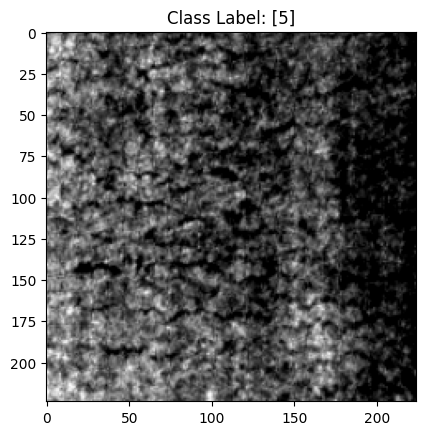

In [ ]:
import matplotlib.pyplot as plt

image_height, image_width, n_color_channels = 224, 224, 3

def parse_tfrecord_function(example_proto):
    feature_description = {
        "image/width": tf.io.FixedLenFeature([], tf.int64),
        "image/height": tf.io.FixedLenFeature([], tf.int64),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/encodedrawdata': tf.io.FixedLenFeature([], tf.string),
        'image/format': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/text': tf.io.VarLenFeature(tf.string),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
        'image/object/class/single': tf.io.FixedLenFeature([], tf.int64),
        'image/object/difficult': tf.io.VarLenFeature(tf.int64),
        'image/object/truncated': tf.io.VarLenFeature(tf.int64),
    }

    parsed_features = tf.io.parse_single_example(example_proto, feature_description)

    # Decoding the raw image data
    image_raw = parsed_features['image/encodedrawdata']
    image = tf.image.decode_jpeg(image_raw, channels=3)
    image = tf.image.resize(image, [image_height, image_width])
    image = tf.keras.applications.xception.preprocess_input(image)

    # Extracting label values from SparseTensor and convert to dense tensor
    label_values = tf.sparse.to_dense(parsed_features['image/object/class/label'])
    label = tf.cast(label_values, tf.int32)

    return image, label


tfrecord_path = "/content/NEU-DET/train/train_out/crazing_1.tfrecord"


dataset = tf.data.TFRecordDataset(tfrecord_path)

# Apply the parsing function to the dataset
parsed_dataset = dataset.map(parse_tfrecord_function)

for image, label in parsed_dataset.take(1):
    plt.imshow(image.numpy())
    plt.title(f"Class Label: {label.numpy()}")
    plt.show()

#Task 2

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint

# Set your dataset-specific values
image_height = 224  # Replace with your actual image height
image_width = 224  # Replace with your actual image width
n_color_channels = 3  # Replace with the number of color channels in your images
n_classes = 6  # Replace with the number of classes in your dataset

# Define the paths to your TFRecord files
train_tfrecord_path = "/content/NEU-DET/train/train_out/*.tfrecord"
test_tfrecord_path = "/content/NEU-DET/validation/validation_out/*.tfrecord"

# Load and preprocess the TFRecord datasets
train_dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(train_tfrecord_path))
test_dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(test_tfrecord_path))

# Function to parse a single TFRecord example
def parse_tfrecord_fn(example):
    feature = {
        "image/width": tf.io.FixedLenFeature([], tf.int64),
        "image/height": tf.io.FixedLenFeature([], tf.int64),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/encodedrawdata': tf.io.FixedLenFeature([], tf.string),
        'image/format': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/text': tf.io.VarLenFeature(tf.string),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
        'image/object/difficult': tf.io.VarLenFeature(tf.int64),
        'image/object/truncated': tf.io.VarLenFeature(tf.int64),
    }
    example = tf.io.parse_single_example(example, feature)
    image = tf.image.decode_jpeg(example["image/encodedrawdata"], channels=n_color_channels)
    label = tf.cast(tf.sparse.to_dense(example["image/object/class/label"]), tf.int32) - 1  # Adjust for 0-based indexing
    return image, label


# Apply parsing function to the datasets and repeat for multiple epochs
batch_size = 32
epochs = 5
steps_per_epoch = 1260 // batch_size

# train_dataset = train_dataset.map(parse_tfrecord_fn).repeat(epochs)
# test_dataset = test_dataset.map(parse_tfrecord_fn).repeat(epochs)
# Apply parsing function to the datasets
train_dataset = train_dataset.map(parse_tfrecord_fn).repeat()
test_dataset = test_dataset.map(parse_tfrecord_fn)

# Create the Xception base model
base_model = Xception(input_shape=(image_height, image_width, n_color_channels),
                      include_top=False,
                      weights='imagenet')

# Add custom classification layers
x = layers.BatchNormalization()(base_model.output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(n_classes, activation='softmax')(x)

# Create model
model = models.Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Print model summary
# model.summary()

# Define training parameters

# Define callbacks
checkpoint_callback = ModelCheckpoint("best_classification_model.h5", save_best_only=True)

# # Train the model
# history = model.fit(train_dataset.batch(batch_size),
#                     epochs=epochs,
#                     steps_per_epoch=steps_per_epoch,
#                     validation_data=test_dataset.batch(batch_size),
#                     callbacks=[checkpoint_callback])
history = model.fit(train_dataset.batch(batch_size),
          epochs=5,
          steps_per_epoch=steps_per_epoch,
          validation_data=test_dataset.batch(batch_size),  callbacks=[checkpoint_callback])


# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset.batch(batch_size))
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


39/39 [==============================] - ETA: 0s - loss: 0.1999 - accuracy: 0.1675

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 97s 737ms/step - loss: 0.1999 - accuracy: 0.1675 - val_loss: 1.7200 - val_accuracy: 0.5868
Epoch 2/5
39/39 [==============================] - 23s 583ms/step - loss: 0.1724 - accuracy: 0.1659 - val_loss: 25.5133 - val_accuracy: 0.1847
Epoch 3/5
39/39 [==============================] - 22s 570ms/step - loss: 0.3120 - accuracy: 0.1562 - val_loss: 247.4100 - val_accuracy: 0.8924
Epoch 4/5
39/39 [==============================] - 21s 551ms/step - loss: 0.1108 - accuracy: 0.1731 - val_loss: 1.8586 - val_accuracy: 0.3924
Epoch 5/5
45/45 [==============================] - 5s 110ms/step - loss: 0.4729 - accuracy: 0.1889
Test Accuracy: 18.89%
Test Loss: 0.4729


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import Xception

#Defining Image Parameters

image_height = 224
image_width = 224
n_color_channels = 1
n_classes = 6

# Load TFRecord dataset
train_filenames = tf.data.Dataset.list_files("/content/NEU-DET/train/train_tfrecords/*.tfrecord")
test_filenames = tf.data.Dataset.list_files("/content/NEU-DET/validation/validation_tfrecords/*.tfrecord")

# Shuffle and repeat the filenames
train_filenames = train_filenames.shuffle(buffer_size=1000)
test_filenames = test_filenames.shuffle(buffer_size=1000)

def parse_tfrecord_fn(example):
    feature_description = {
        "image/width": tf.io.FixedLenFeature([], tf.int64),
        "image/height": tf.io.FixedLenFeature([], tf.int64),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/encodedrawdata': tf.io.FixedLenFeature([], tf.string),
        'image/format': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/text': tf.io.VarLenFeature(tf.string),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
        'image/object/difficult': tf.io.VarLenFeature(tf.int64),
        'image/object/truncated': tf.io.VarLenFeature(tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)

    # Decode image and resize
    image = tf.image.decode_jpeg(example['image/encodedrawdata'], channels=1)  # Black and white image
    image = tf.image.resize(image, [224, 224])  # Resize to Xception input size
    image = tf.image.grayscale_to_rgb(image)  # Convert to RGB
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values

    label = tf.cast(example['image/object/class/label'].values[0], tf.int32)
    return image, label

# Load and preprocess dataset
def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(parse_tfrecord_fn)
    return dataset

batch_size = 16

# Load and preprocess train and test datasets
train_dataset = train_filenames.interleave(load_dataset, cycle_length=4, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_filenames.interleave(load_dataset, cycle_length=4, num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset = train_dataset.repeat()

train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Define base Xception model
base_model = Xception(input_shape=(image_height, image_width, 3),  # Assuming RGB images have 3 channels
                      include_top=False,
                      weights='imagenet')

# Add custom classification layers
x = layers.BatchNormalization()(base_model.output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(8, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(n_classes, activation='softmax')(x)

# Create the model
model = models.Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
# Calculate the number of steps per epoch based on the size of your dataset and the batch size
# 1400 = length of training samples

steps_per_epoch = 1400 // batch_size

# Train the model with the specified steps_per_epoch parameter
model.fit(train_dataset,
          epochs=5,
          steps_per_epoch=steps_per_epoch,
          validation_data=test_dataset)


# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


39/39 [==============================] - 1012s 26s/step - loss: 1.1890 - accuracy: 0.4127 - val_loss: 1.2621 - val_accuracy: 0.4639
Epoch 2/5
39/39 [==============================] - 989s 25s/step - loss: 1.0482 - accuracy: 0.5521 - val_loss: 3.0864 - val_accuracy: 0.4833
Epoch 3/5
39/39 [==============================] - 987s 25s/step - loss: 0.8686 - accuracy: 0.5817 - val_loss: 1.0575 - val_accuracy: 0.5972
Epoch 4/5
39/39 [==============================] - 958s 25s/step - loss: 0.8571 - accuracy: 0.6058 - val_loss: 2.4489 - val_accuracy: 0.4083
Epoch 5/5
12/12 [==============================] - 60s 5s/step - loss: 3.5642 - accuracy: 0.3583
Test Loss: 3.5641915798187256
Test Accuracy: 0.3583333194255829


As we can see, the loss explodes in the end, indicating poor data quality, or overfitting.